[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📥 Input Query: how could HPE’s focus on sustainability have influenced its 2025 profitability?
✅ Predicted Class(es):
  - Reasoning/Inference: 0.8078

📊 All Class Probabilities:
  Aggregate/Time-Based: 0.0316
  Factual: 0.0180
  Global Sensing/Summary: 0.1357
  Multi-Part: 0.0069
  Reasoning/Inference: 0.8078

🔍 Entropy (Uncertainty Score): 0.6592


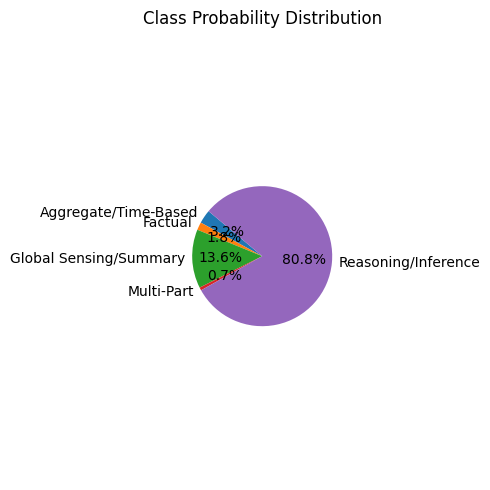

{'multi_predicted_classes': [np.str_('Reasoning/Inference')],
 'probabilities': {np.str_('Aggregate/Time-Based'): np.float64(0.03156253790094689),
  np.str_('Factual'): np.float64(0.01804226010070933),
  np.str_('Global Sensing/Summary'): np.float64(0.13569079579664733),
  np.str_('Multi-Part'): np.float64(0.006877665977166463),
  np.str_('Reasoning/Inference'): np.float64(0.8078267402245299)},
 'entropy': np.float64(0.6591829041487816)}

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np
import joblib
import nltk
from nltk import word_tokenize
import string

# Download NLTK tokenizer
nltk.download('punkt')

# ==== Load Embedder ====
def get_embedder(model_name="all-MiniLM-L6-v2"):
    return SentenceTransformer(model_name)

# ==== Define Auxiliary Feature Function ====
import spacy
from spacy.matcher import PhraseMatcher

# Load transformer-based model
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

# Setup custom financial phrases for matching
custom_phrases = [
    "hpe", "gaap", "arr", "eps", "free cash flow", "revenue",
    "profit margin", "intelligent edge", "hybrid cloud", "financial services"
]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in custom_phrases]
matcher.add("CUSTOM_ENTITIES", patterns)

def extract_auxiliary_features(text):
    text = text.lower()
    doc = nlp(text)

    # Keyword categories
    question_words = {"what", "when", "how", "why", "where", "who", "which"}
    time_refs = {"q1", "q2", "q3", "q4", "quarter", "year", "annual", "fy", "fiscal", "2021", "2022", "2023", "2024", "2025"}
    summary_keywords = {"summary", "summarize", "highlight", "overview", "key points", "takeaways"}
    reasoning_keywords = {"impact", "why", "how did", "change", "affect", "reason", "cause", "contribute", "influence", "due to"}
    aggregation_keywords = {"compare", "trend", "growth", "increase", "decrease", "from", "to", "cumulative", "average", "total", "over time"}
    superlative_keywords = {"highest", "lowest", "most", "least", "maximum", "minimum", "peak", "top"}
    multi_part_keywords = [" and ", " also ", " as well as ", " together ", "both", "respectively"]
    # Domain-specific keywords for deeper intent detection
    segment_keywords = ["hybrid cloud", "intelligent edge", "financial services"]
    metric_keywords = ["revenue", "arr", "eps", "free cash flow"]

    range_year_phrases = ["2023 and 2024", "last 2 years", "past 3 years", "fiscal 2023 to 2024"]
    quarter_keywords = ["q1", "q2", "q3", "q4"]
    change_terms = ["change", "trend", "shift", "evolve", "improvement", "decline"]
    comparison_terms = ["compare", "versus", "vs", "over", "between"]
    aggregation_terms = ["average", "cumulative", "total", "combined", "sum"]

    # NER + PhraseMatcher
    matched_custom_entities = matcher(doc)
    num_custom_entities = len(matched_custom_entities)
    ner_labels = [ent.label_ for ent in doc.ents]
    ner_texts = [ent.text.lower() for ent in doc.ents]

    # POS features
    pos_tags = [token.pos_ for token in doc]
    tag_labels = [token.tag_ for token in doc]

    features = {
        # Basic structural features
        "token_len": len(doc),
        "num_nouns": pos_tags.count("NOUN"),
        "num_verbs": pos_tags.count("VERB"),
        "num_conj": sum(1 for tok in doc if tok.text in {"and", "or", ","}),
        "has_past_tense": sum(1 for tok in doc if tok.tag_ == "VBD"),
        "has_modal": int(any(tok.tag_ == "MD" for tok in doc)),
        "has_auxiliary": int(any(tok.dep_ == "aux" for tok in doc)),
        "has_numeric_value": int(any(tok.like_num for tok in doc)),

        # Question / structure
        "starts_with_question_word": int(doc[0].text in question_words),
        "num_question_words": sum(1 for tok in doc if tok.text in question_words),

        # Semantic categories
        "num_time_refs": sum(1 for tok in doc if tok.text in time_refs),
        "has_multiple_time_refs": int(len([tok for tok in doc if tok.text in time_refs]) > 1),
        "has_from_to_range": int("from" in text and "to" in text),

        "num_summary_keywords": sum(1 for word in summary_keywords if word in text),
        "num_reasoning_keywords": sum(1 for word in reasoning_keywords if word in text),
        "num_aggregation_keywords": sum(1 for word in aggregation_keywords if word in text),
        "num_superlatives": sum(1 for word in superlative_keywords if word in text),
        "num_multi_part_keywords": sum(1 for phrase in multi_part_keywords if phrase in text),

        # Domain relevance
        "num_custom_entities": num_custom_entities,
        "num_money_entities": ner_labels.count("MONEY"),
        "num_date_entities": ner_labels.count("DATE"),
            # Domain-specific pattern-based features
    "mentions_segment": int(any(seg in text for seg in segment_keywords)),
    "mentions_fin_metric": int(any(fin in text for fin in metric_keywords)),
    "mentions_multiple_segments": int(sum(seg in text for seg in segment_keywords) > 1),
    "mentions_multiple_metrics": int(sum(fin in text for fin in metric_keywords) > 1),

    "mentions_range_years": int(any(phrase in text for phrase in range_year_phrases)),
    "mentions_multiple_quarters": int(sum(q in text for q in quarter_keywords) > 1),
    "mentions_change_term": int(any(term in text for term in change_terms)),
    "mentions_comparison_term": int(any(term in text for term in comparison_terms)),
    "mentions_aggregation": int(any(term in text for term in aggregation_terms)),

        # Entity richness
        "unique_ner_types": len(set(ner_labels)),
        "num_entities": len(doc.ents),
    }

    return list(features.values())



# ==== Explain Prediction Function ====
def explain_prediction(
    text_query,
    model,
    embedder,
    aux_feature_fn,
    label_encoder,
    uncertainty_threshold=1.0,
    prob_diff_threshold=.2,
    show_plot=True
):
    # === 1. Build Full Feature Vector ===
    embedding = embedder.encode([text_query])
    aux_features = np.array([aux_feature_fn(text_query)])
    X_input = np.hstack([embedding, aux_features])

    # === 2. Predict Probabilities ===
    probs = model.predict_proba(X_input)[0]  # returns [n_classes] shape

    # === 3. Decode Class Names ===
    class_names = label_encoder.classes_

    # === 4. Sort and Filter Top Predictions ===
    sorted_indices = np.argsort(probs)[::-1]
    top_prob = probs[sorted_indices[0]]

    predicted_classes = []
    for idx in sorted_indices:
        if top_prob - probs[idx] <= prob_diff_threshold:
            predicted_classes.append((class_names[idx], probs[idx]))
        else:
            break

    # === 5. Entropy (Uncertainty) ===
    entropy_val = entropy(probs)

    # === 6. Print Results ===
    print(f"\n📥 Input Query: {text_query}")
    print("✅ Predicted Class(es):")
    for cls, prob in predicted_classes:
        print(f"  - {cls}: {prob:.4f}")

    print("\n📊 All Class Probabilities:")
    for idx, prob in enumerate(probs):
        print(f"  {class_names[idx]}: {prob:.4f}")

    print(f"\n🔍 Entropy (Uncertainty Score): {entropy_val:.4f}")
    if entropy_val > uncertainty_threshold:
        print("⚠️  Warning: Prediction uncertain. Please double-check.")

    # === 7. Pie Chart ===
    if show_plot:
        plt.figure(figsize=(5, 5))
        plt.pie(probs, labels=class_names, autopct='%1.1f%%', startangle=140)
        plt.title("Class Probability Distribution")
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    # === 8. Return as Dictionary ===
    return {
        "multi_predicted_classes": [cls for cls, _ in predicted_classes],
        "probabilities": dict(zip(class_names, probs)),
        "entropy": entropy_val
    }

model = joblib.load("/content/HPE_multiclass_query_classifier.pkl")
embedder = get_embedder()
aux_feature_fn = extract_auxiliary_features
label_encoder = joblib.load("/content/label_encoder.pkl")
# ==== Sample Query ====
query = "how could HPE’s focus on sustainability have influenced its 2025 profitability?"
explain_prediction(
    text_query=query,
    model=model,
    embedder=embedder,
    aux_feature_fn=aux_feature_fn,
    label_encoder=label_encoder,
    show_plot=True
)
